<a href="https://colab.research.google.com/github/minhdvo/bai_tap/blob/master/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# This notebook was created and run in Google Colab
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pylab import imread,subplot,imshow,show
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

from keras.preprocessing.image import load_img
from keras.layers import Input, Activation, BatchNormalization, Add, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import seaborn as sns

from sklearn.model_selection import train_test_split
from skimage.transform import resize

import tensorflow as tf

Using TensorFlow backend.


##Copy data from kaggle


In [0]:
# kaggle competitions download -c tgs-salt-identification-challenge
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
%ls

gdrive/  sample_data/


In [4]:
%pwd

'/content'

In [5]:
cd gdrive/My\ Drive/code/py/pro_ii

/content/gdrive/My Drive/code/py/pro_ii


In [6]:
%ls

'Capstone Project 2 Ideas.docx'     Project-Proposal.docx
 Capstone_Project_2_proposal.docx   sample_submission.csv
 depths.csv                         submission_file.csv
 EDA.ipynb                          test/
 image-tgs-salt.ipynb               train/
 Milestone-1.ipynb                  train.csv
 Milestone_2.ipynb                  unet_best1.model
'Milestone Report 1.docx'


In [7]:
%pwd

'/content/gdrive/My Drive/code/py/pro_ii'

# Load data

In [0]:
# train - only index
train = pd.read_csv("train.csv", index_col="id", usecols=[0])
depth = pd.read_csv("depths.csv", index_col="id")
# add depth into train
train = train.join(depth)
# all index and depths are not in train
depth_others = depth[~depth.index.isin(train.index)]


In [9]:
# add info of image into train
train["images"] = [np.array(load_img("train/images/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm_notebook(train.index)]

In [10]:
# add value of mask into train
train["masks"] = [np.array(load_img("train/masks/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm_notebook(train.index)]

In [0]:
# compute the coverage of image
img_size = 101
train["coverage"] = train.masks.map(np.sum) / (img_size** 2)

In [0]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train["coverage_class"] = train.coverage.map(cov_to_class)

# Split data

In [0]:
def upsample(img):    
    return resize(img, (img_size, img_size), mode='constant', preserve_range=True)

In [0]:
# train/validation split
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train.index.values,
    np.array(train.images.map(upsample).tolist()).reshape(-1, img_size, img_size, 1), 
    np.array(train.masks.map(upsample).tolist()).reshape(-1, img_size, img_size, 1), 
    train.coverage.values,
    train.z.values,
    test_size=0.3, stratify=train.coverage_class, random_state= 1)

# Model

In [0]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = Activation('relu')(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = Activation('relu')(blockInput)
    x = BatchNormalization()(x)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [0]:
# Model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16)
    convm = Activation('relu')(convm)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = Activation('relu')(uconv4)
    
    # 12 -> 25    
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = Activation('relu')(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = Activation('relu')(uconv2)
    
    # 50 -> 101    
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = Activation('relu')(uconv1)
    
    uconv1 = Dropout(DropoutRatio/2)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [0]:
# Accuracy metric
# Intersection over union (IoU) 
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in

    true_objects = 2
    pred_objects = 2

    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
    intersection = temp1[0]

    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    y_pred_in = y_pred_in > 0.5 
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)    
    return np.mean(metric)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float64)
    return metric_value

In [18]:
x_train_1 = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train_1 = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train_1.shape)
print(y_valid.shape)

(5600, 101, 101, 1)
(1200, 101, 101, 1)


In [19]:
# Build model
input_layer = Input((img_size, img_size, 1))
output_layer = build_model(input_layer, 16, 0.5)

model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[my_iou_metric])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 101, 101, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 101, 101, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 101, 101, 16) 64          activation_1[0][0]               
__________________________________________________________________________________________________
conv2d_2 (

In [21]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint("./unet_best.model",monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',factor=0.2, patience=5, min_lr=0.0001, verbose=1)

epochs = 60
batch_size = 32

history = model.fit(x_train_1, y_train_1,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=2)

Train on 5600 samples, validate on 1200 samples
Epoch 1/60
 - 82s - loss: 0.1912 - my_iou_metric: 0.5867 - val_loss: 0.2084 - val_my_iou_metric: 0.6283

Epoch 00001: val_my_iou_metric improved from -inf to 0.62833, saving model to ./unet_best.model
Epoch 2/60
 - 82s - loss: 0.1828 - my_iou_metric: 0.6050 - val_loss: 0.2042 - val_my_iou_metric: 0.6229

Epoch 00002: val_my_iou_metric did not improve from 0.62833
Epoch 3/60
 - 82s - loss: 0.1747 - my_iou_metric: 0.6232 - val_loss: 0.1653 - val_my_iou_metric: 0.6868

Epoch 00003: val_my_iou_metric improved from 0.62833 to 0.68683, saving model to ./unet_best.model
Epoch 4/60
 - 82s - loss: 0.1681 - my_iou_metric: 0.6443 - val_loss: 0.1644 - val_my_iou_metric: 0.7119

Epoch 00004: val_my_iou_metric improved from 0.68683 to 0.71192, saving model to ./unet_best.model
Epoch 5/60
 - 82s - loss: 0.1607 - my_iou_metric: 0.6628 - val_loss: 0.1565 - val_my_iou_metric: 0.7151

Epoch 00005: val_my_iou_metric improved from 0.71192 to 0.71508, saving m

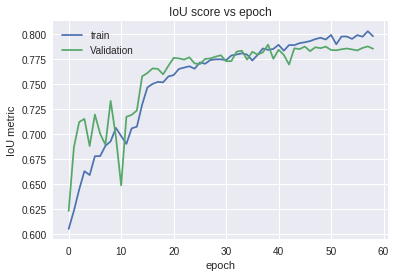

In [22]:
# IoU_metric plot
plt.plot(history.history['my_iou_metric'][1:])
plt.plot(history.history['val_my_iou_metric'][1:])
plt.title('IoU score vs epoch')
plt.ylabel('IoU metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='best')
plt.show()

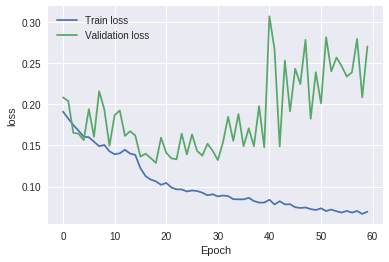

In [23]:
# Loss
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Validation loss")
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

In [0]:
model = load_model("./unet_best.model",custom_objects={'my_iou_metric': my_iou_metric})

In [0]:
def predict_result(model,x_test,img_size_target): 
    # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test1 = model.predict(x_test).reshape(-1, img_size, img_size)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size, img_size)
    preds_test2 = np.array([ np.fliplr(x) for x in preds_test2_refect] )
    preds_avg = (preds_test1 + preds_test2)/2
    return preds_avg

In [0]:
def downsample(img):
    return resize(img, (img_size, img_size), mode='constant', preserve_range=True)

preds_valid = predict_result(model,x_valid,img_size)
preds_valid2 = np.array([downsample(x) for x in preds_valid])

y_valid2 = np.array([downsample(x) for x in y_valid])

In [27]:
## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(y_valid2, np.int32(preds_valid2 > threshold)) for threshold in tqdm_notebook(thresholds)])

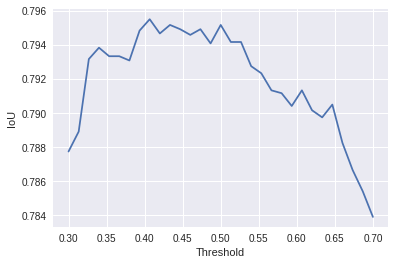

In [28]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.show()

In [29]:
print("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))

Threshold vs IoU (0.4066666666666666, 0.7955)


# Test set

In [0]:
def rle_encode(im):
    """
    used for converting the decoded image to rle mask
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    """
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [31]:
x_test = np.array([(np.array(load_img("test/images/{}.png".format(idx), color_mode = "grayscale"))) / 255 for idx in tqdm_notebook(depth_others.index)]).reshape(-1, img_size, img_size, 1)

In [0]:
preds_test = predict_result(model,x_test,img_size)

# Output

In [33]:
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(depth_others.index.values))}

In [0]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('final_prediction.csv')

In [35]:
sub.head(10)

rle_mask
id                                                           
353e010b7b                                                   
5439dbbddf                                                   
71bab9f311                                                   
52551f7a80                                                   
512d8d9997  1 31 102 31 203 31 304 31 405 30 506 29 607 28...
64dba827d6                                                   
0a3a8a5f37                                                   
329563756f  1 4847 4849 100 4950 99 5051 98 5152 98 5253 9...
f6cba2e890                                                   
989c646373

# Figure of test set

In [0]:
import matplotlib.image as mpimg

File ID: 71bab9f311


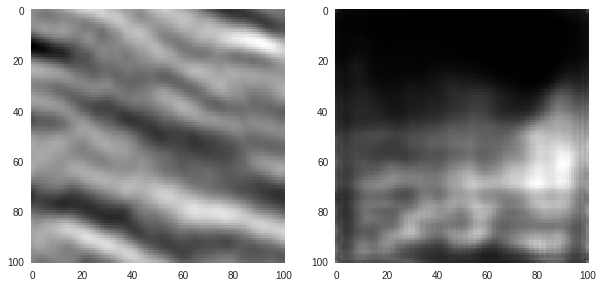

In [81]:
print('File ID: ' + depth_others.index[2])
plt.figure(figsize=(10, 10))

img = mpimg.imread('test/images/'+depth_others.index[2]+'.png')
plt.subplot(121)
plt.grid(False)
plt.imshow(img)

plt.subplot(122)
plt.imshow(preds_test[2],cmap='gray')
plt.grid(False)
plt.show()

File ID: 5439dbbddf


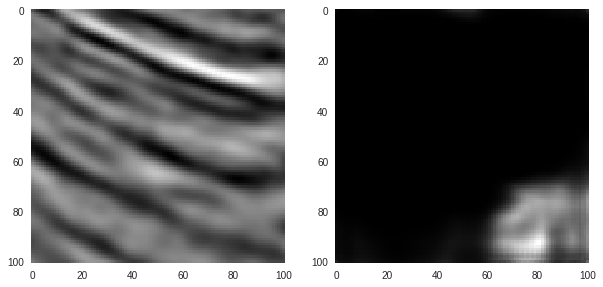

In [79]:
print('File ID: ' + depth_others.index[1])
plt.figure(figsize=(10, 10))

img = mpimg.imread('test/images/'+depth_others.index[1]+'.png')
plt.subplot(121)
plt.grid(False)
plt.imshow(img)

plt.subplot(122)
plt.imshow(preds_test[1],cmap='gray')
plt.grid(False)
plt.show()

File ID: 512d8d9997


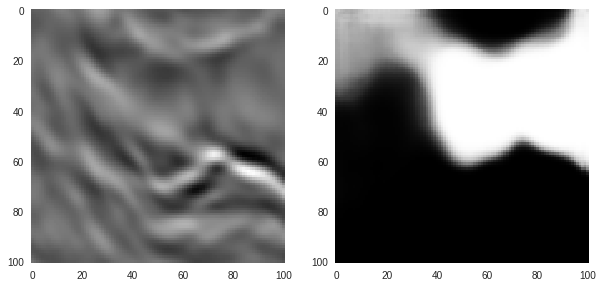

In [84]:
i=4
print('File ID: ' + depth_others.index[i])
plt.figure(figsize=(10, 10))

img = mpimg.imread('test/images/'+depth_others.index[i]+'.png')
plt.subplot(121)
plt.grid(False)
plt.imshow(img)

plt.subplot(122)
plt.imshow(preds_test[i],cmap='gray')
plt.grid(False)
plt.show()

File ID: aa5f085ae7


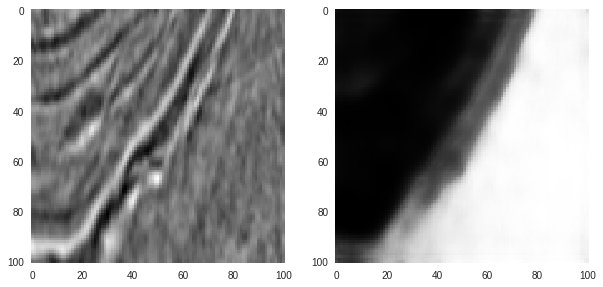

In [94]:
i=13
print('File ID: ' + depth_others.index[i])
plt.figure(figsize=(10, 10))

img = mpimg.imread('test/images/'+depth_others.index[i]+'.png')
plt.subplot(121)
plt.grid(False)
plt.imshow(img)

plt.subplot(122)
plt.imshow(preds_test[i],cmap='gray')
plt.grid(False)
plt.show()

File ID: 51caea4f7a


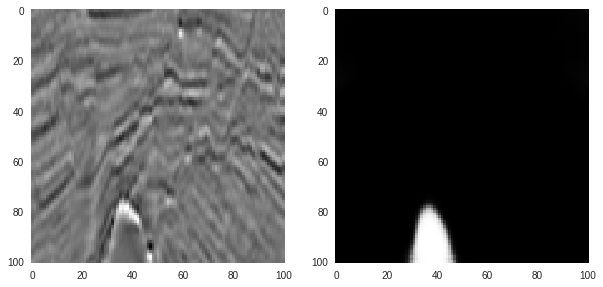

In [95]:
i=14
print('File ID: ' + depth_others.index[i])
plt.figure(figsize=(10, 10))

img = mpimg.imread('test/images/'+depth_others.index[i]+'.png')
plt.subplot(121)
plt.grid(False)
plt.imshow(img)

plt.subplot(122)
plt.imshow(preds_test[i],cmap='gray')
plt.grid(False)
plt.show()

In [0]:
# save data
np.save('pred_test',preds_test)
depth_others.to_csv('depth_test.csv')

# Figure for train

File ID: 09541ce79b


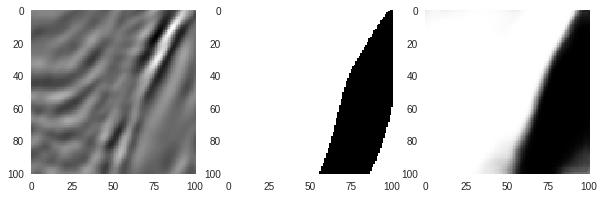

In [115]:
i=0
print('File ID: ' + ids_valid[i])
plt.figure(figsize=(10, 10))

img = mpimg.imread('train/images/'+ids_valid[i]+'.png')
plt.subplot(131)
plt.grid(False)
plt.imshow(img)

plt.subplot(132)
img = mpimg.imread('train/masks/'+ids_valid[i]+'.png')
plt.grid(False)
plt.imshow(img)

plt.subplot(133)
plt.imshow(1-preds_valid2[i],cmap='gray')
plt.grid(False)
plt.show()

File ID: 3c9931bca2


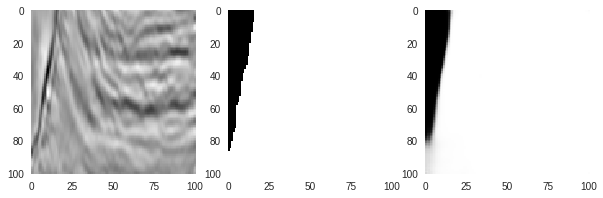

In [116]:
i=2
print('File ID: ' + ids_valid[i])
plt.figure(figsize=(10, 10))

img = mpimg.imread('train/images/'+ids_valid[i]+'.png')
plt.subplot(131)
plt.grid(False)
plt.imshow(img)

plt.subplot(132)
img = mpimg.imread('train/masks/'+ids_valid[i]+'.png')
plt.grid(False)
plt.imshow(img)

plt.subplot(133)
plt.imshow(1-preds_valid2[i],cmap='gray')
plt.grid(False)
plt.show()

File ID: b28aeb78e0


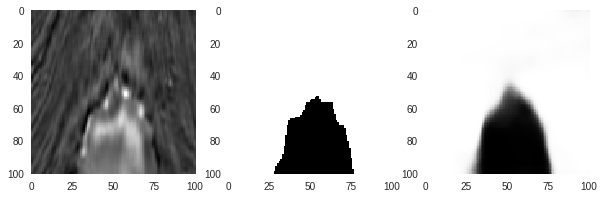

In [117]:
i=3
print('File ID: ' + ids_valid[i])
plt.figure(figsize=(10, 10))

img = mpimg.imread('train/images/'+ids_valid[i]+'.png')
plt.subplot(131)
plt.grid(False)
plt.imshow(img)

plt.subplot(132)
img = mpimg.imread('train/masks/'+ids_valid[i]+'.png')
plt.grid(False)
plt.imshow(img)

plt.subplot(133)
plt.imshow(1-preds_valid2[i],cmap='gray')
plt.grid(False)
plt.show()

File ID: df8caa8bdf


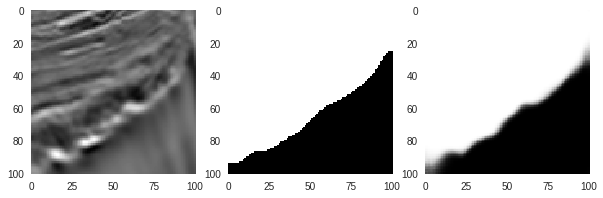

In [118]:
i=4
print('File ID: ' + ids_valid[i])
plt.figure(figsize=(10, 10))

img = mpimg.imread('train/images/'+ids_valid[i]+'.png')
plt.subplot(131)
plt.grid(False)
plt.imshow(img)

plt.subplot(132)
img = mpimg.imread('train/masks/'+ids_valid[i]+'.png')
plt.grid(False)
plt.imshow(img)

plt.subplot(133)
plt.imshow(1-preds_valid2[i],cmap='gray')
plt.grid(False)
plt.show()

File ID: 6138f82415


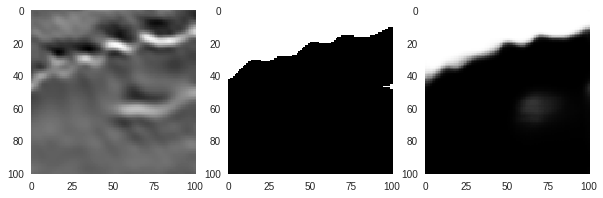

In [119]:
i=5
print('File ID: ' + ids_valid[i])
plt.figure(figsize=(10, 10))

img = mpimg.imread('train/images/'+ids_valid[i]+'.png')
plt.subplot(131)
plt.grid(False)
plt.imshow(img)

plt.subplot(132)
img = mpimg.imread('train/masks/'+ids_valid[i]+'.png')
plt.grid(False)
plt.imshow(img)

plt.subplot(133)
plt.imshow(1-preds_valid2[i],cmap='gray')
plt.grid(False)
plt.show()

File ID: 31a4341eb6


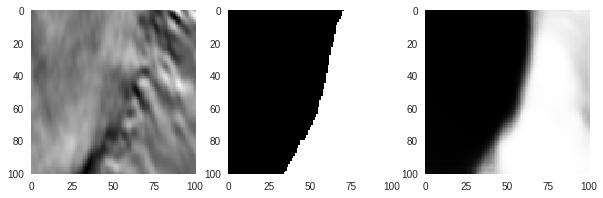

In [120]:
i=6
print('File ID: ' + ids_valid[i])
plt.figure(figsize=(10, 10))

img = mpimg.imread('train/images/'+ids_valid[i]+'.png')
plt.subplot(131)
plt.grid(False)
plt.imshow(img)

plt.subplot(132)
img = mpimg.imread('train/masks/'+ids_valid[i]+'.png')
plt.grid(False)
plt.imshow(img)

plt.subplot(133)
plt.imshow(1-preds_valid2[i],cmap='gray')
plt.grid(False)
plt.show()

File ID: a21ae8cb6b


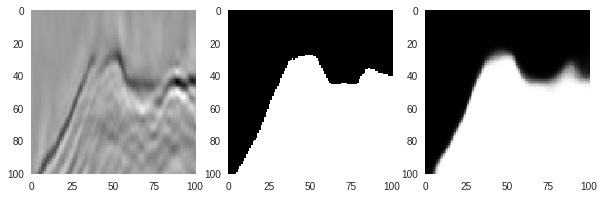

In [121]:
i=7
print('File ID: ' + ids_valid[i])
plt.figure(figsize=(10, 10))

img = mpimg.imread('train/images/'+ids_valid[i]+'.png')
plt.subplot(131)
plt.grid(False)
plt.imshow(img)

plt.subplot(132)
img = mpimg.imread('train/masks/'+ids_valid[i]+'.png')
plt.grid(False)
plt.imshow(img)

plt.subplot(133)
plt.imshow(1-preds_valid2[i],cmap='gray')
plt.grid(False)
plt.show()

File ID: ceca04aa2a


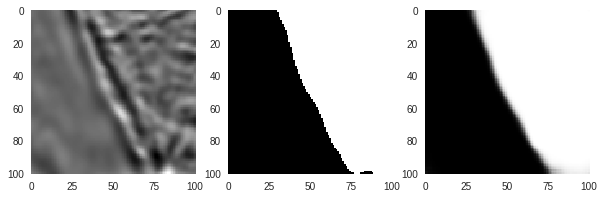

In [114]:
i=11
print('File ID: ' + ids_valid[i])
plt.figure(figsize=(10, 10))

img = mpimg.imread('train/images/'+ids_valid[i]+'.png')
plt.subplot(131)
plt.grid(False)
plt.imshow(img)

plt.subplot(132)
img = mpimg.imread('train/masks/'+ids_valid[i]+'.png')
plt.grid(False)
plt.imshow(img)

plt.subplot(133)
plt.imshow(1-preds_valid2[i],cmap='gray')
plt.grid(False)
plt.show()

File ID: 418a13df5c


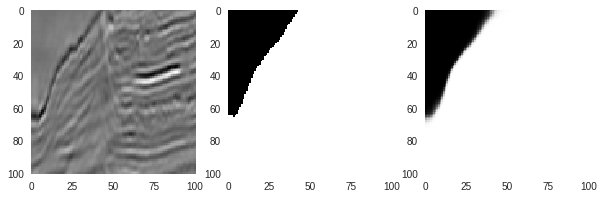

In [122]:
i=110
print('File ID: ' + ids_valid[i])
plt.figure(figsize=(10, 10))

img = mpimg.imread('train/images/'+ids_valid[i]+'.png')
plt.subplot(131)
plt.grid(False)
plt.imshow(img)

plt.subplot(132)
img = mpimg.imread('train/masks/'+ids_valid[i]+'.png')
plt.grid(False)
plt.imshow(img)

plt.subplot(133)
plt.imshow(1-preds_valid2[i],cmap='gray')
plt.grid(False)
plt.show()

In [0]:
# save data file
np.save('ids_valid',ids_valid)
np.save('preds_valid',preds_valid2)